In [4]:
import pandas as pd
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from metrics import metrics
from matplotlib import pyplot as plt

In [5]:
RS = 42

## Random Forest

Выяснили:
1. Отношение сплита тренировочных данных особо на результат не влияет, то есть неравномерности в выборке нет.
2. Удаление коррелирующих параметров сильно на результат не влияет, только на скорость обучения. Разве что если удалить много параметров, показатели сильно ухудшаются.
3. Андерсэмплинг датасета чуть лучше чем балансировка весов, но с балансировкой есть возможность увеличить recall.

### 1. Разбиение данных

Accuracy:   0.9405247364776487
Precision:  0.8809523809523809
Recall:     0.4776006074411541
F1:         0.6193993106843919


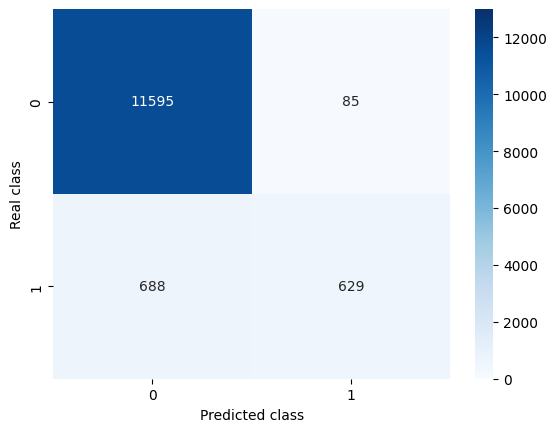

Accuracy:   0.941064833812064
Precision:  0.8733205374280231
Recall:     0.4722366372599896
F1:         0.613001010441226


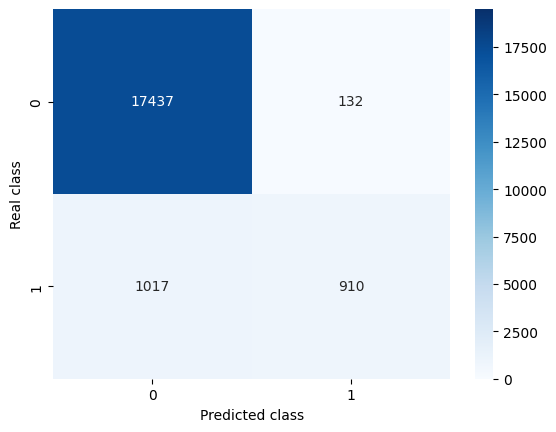

Accuracy:   0.9400630914826499
Precision:  0.8484455958549223
Recall:     0.4973424449506454
F1:         0.627094303494495


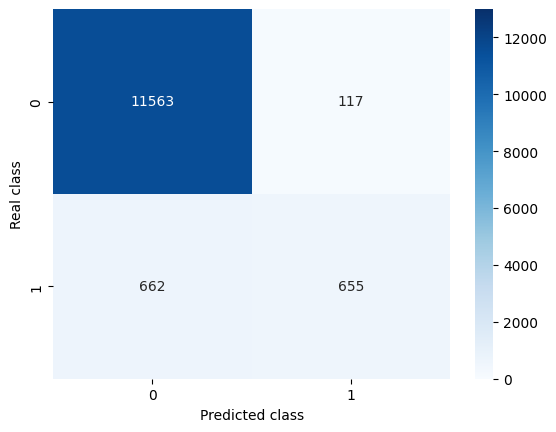

Accuracy:   0.939936397209684
Precision:  0.8526315789473684
Recall:     0.4921518987341772
F1:         0.6240770465489567


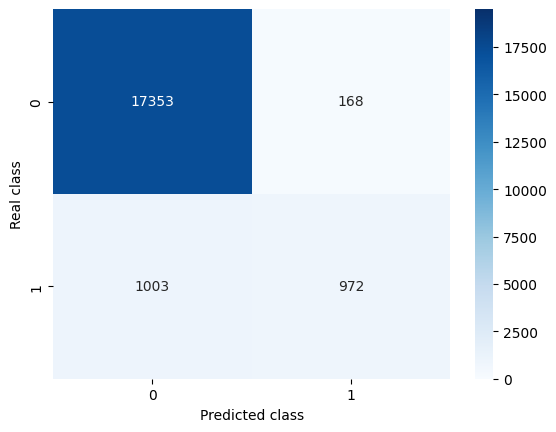

In [6]:
data = pd.read_csv("../data/whole_data.csv").iloc[:, 4:].drop("type", axis=1).dropna()

features, labels = data.drop("present", axis=1), data["present"]

splits = [train_test_split(features, labels, random_state=RS, train_size=0.8),
          train_test_split(features, labels, random_state=RS, train_size=0.7),
          train_test_split(features, labels, random_state=RS, train_size=0.8, stratify=labels),
          train_test_split(features, labels, random_state=RS, train_size=0.7, stratify=labels)]

for sp in splits:
  clf = RandomForestClassifier(n_jobs=-1)
  clf.fit(sp[0], sp[2])
  metrics(clf.predict(sp[1]), sp[3])

**Recall** показывает насколько много в определенных как переменные переменных.

**Precision** показывает насколько много переменных звезд мы не упустили.

### 2. Коррелирующие параметры

<Axes: >

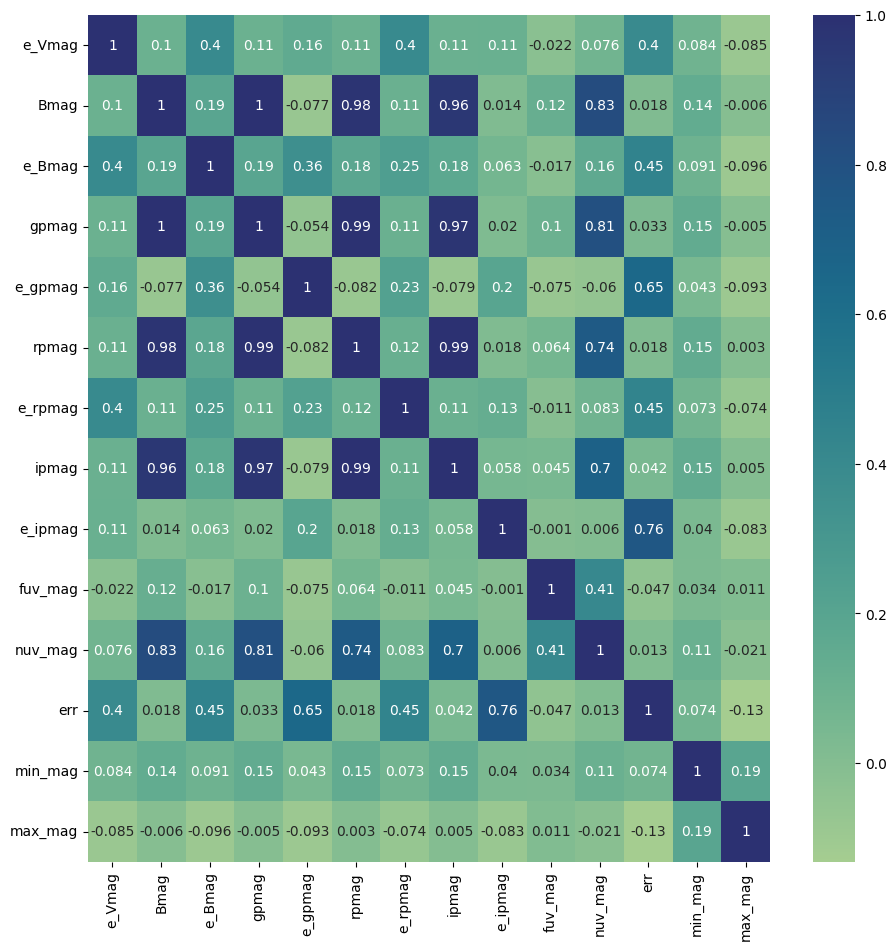

In [7]:
plt.figure(figsize=(11, 11))

corr = features.corr()
sns.heatmap(corr.round(3), cmap="crest", annot=True)

In [8]:
candidates = []  # видно, что связаны одни и те же, поэтому одномерного списка достаточно
treshold = 0.8
for row in corr.iterrows():
  for col in row[1].items():
    if row[0] != col[0] and col[1] > treshold and col[0] not in candidates:
      candidates.append(col[0])

candidates

['gpmag', 'rpmag', 'ipmag', 'nuv_mag', 'Bmag']

Accuracy:   0.9384473340001539
Precision:  0.873015873015873
Recall:     0.45937737281700836
F1:         0.6019900497512438


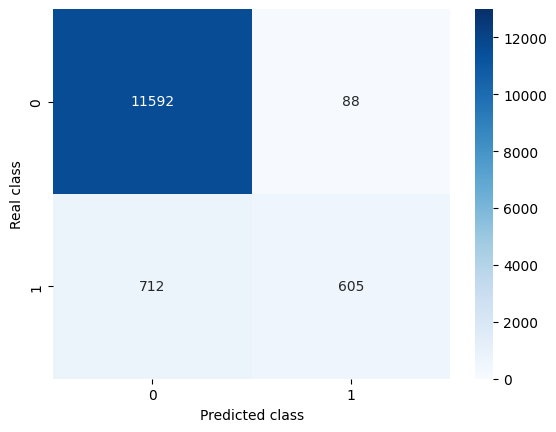

Accuracy:   0.9362160498576595
Precision:  0.8910256410256411
Recall:     0.42217160212604404
F1:         0.5729005667181865


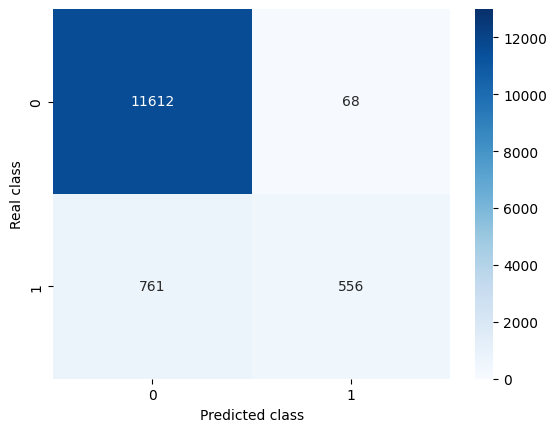

Accuracy:   0.9281372624451797
Precision:  0.8762278978388998
Recall:     0.33864844343204253
F1:         0.488499452354874


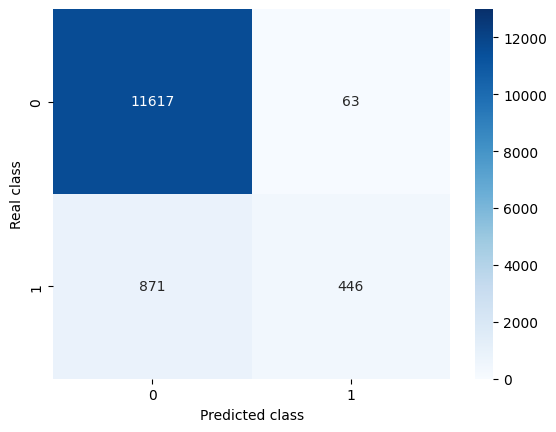

Accuracy:   0.9189813033777026
Precision:  0.8419689119170984
Recall:     0.24677296886864086
F1:         0.3816793893129771


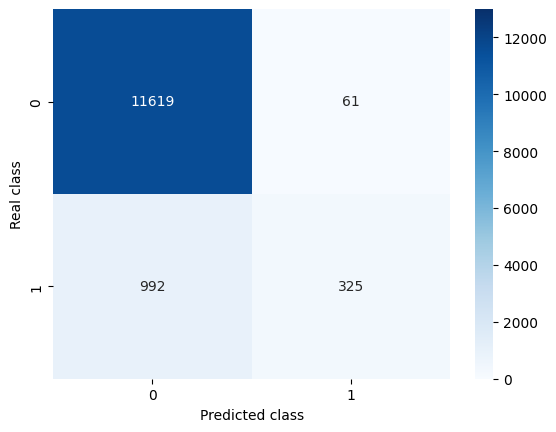

In [9]:
features_copy = features.copy()
# хотя бы один из связанных должен остаться
draw_data = []
for c in candidates[:-1]:
  features_copy.drop(c, inplace=True, axis=1)
  sp = train_test_split(features_copy, labels, random_state=RS, train_size=0.8)
  clf = RandomForestClassifier(n_jobs=-1)
  clf.fit(sp[0], sp[2])
  draw_data.append(metrics(clf.predict(sp[1]), sp[3]))
  draw_data[-1]["Deleted"] = c

# sns.relplot(draw_data)
# можно понять, что nuv_magnitude is important

<Axes: xlabel='Deleted'>

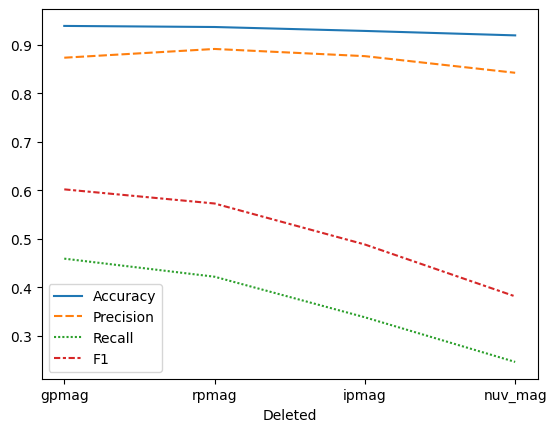

In [10]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["Deleted"])
sns.lineplot(draw_df)

### 3. Undersmapling vs balanced

In [11]:
X, x, Y, y = train_test_split(features, labels, random_state=RS, train_size=0.8)

classes = Y.unique()
weights = [compute_class_weight('balanced', classes=classes, y=Y)]
weights

[array([0.55636772, 4.93516233])]

With weight [0.55636772 4.93516233]
Accuracy:   0.9361391090251596
Precision:  0.8798751950078003
Recall:     0.428246013667426
F1:         0.5760980592441267


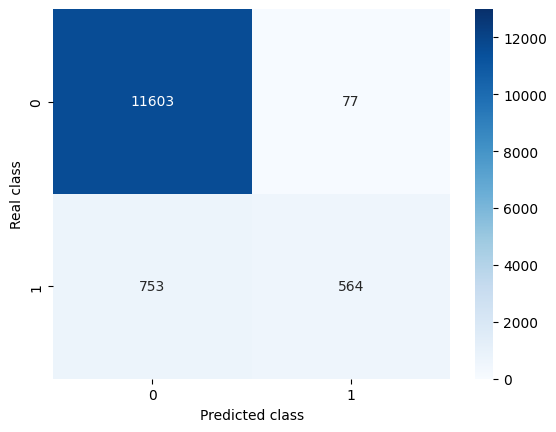

With weight [1, 20]
Accuracy:   0.9362160498576595
Precision:  0.8910256410256411
Recall:     0.42217160212604404
F1:         0.5729005667181865


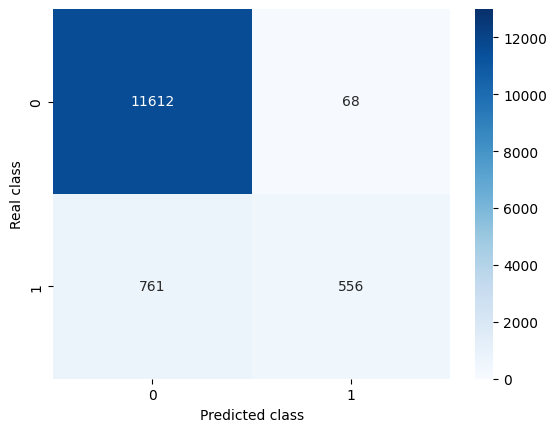

With weight [1, 30]
Accuracy:   0.9369085173501577
Precision:  0.8888888888888888
Recall:     0.4312832194381169
F1:         0.5807770961145194


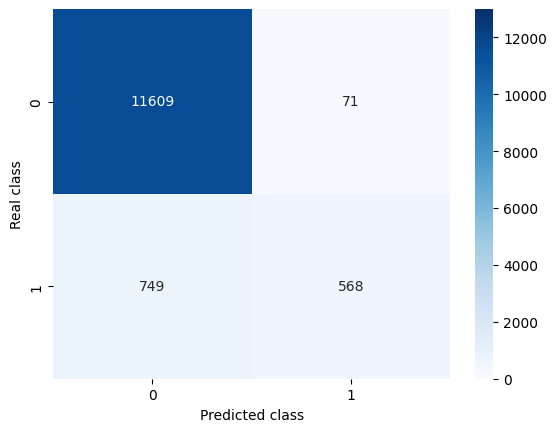

With weight [1, 60]
Accuracy:   0.9359082865276602
Precision:  0.8928571428571429
Recall:     0.4176157934700076
F1:         0.5690636316606311


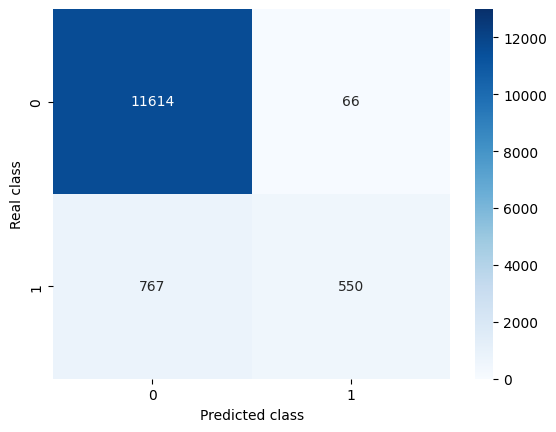

In [12]:
weights += [[1, 20], [1, 30], [1, 60]]

# в декоратор бы это все)
draw_data = []
for w in weights:
  clf = RandomForestClassifier(class_weight=dict(zip(classes, w)), n_jobs=-1)
  clf.fit(X, Y)
  print(f"With weight {w}")
  draw_data.append(metrics(clf.predict(x), y))
  draw_data[-1]["Weights"] = round(w[1] / w[0], 2)

Видно, что веса особо эффекта не приносят

<Axes: xlabel='Weights'>

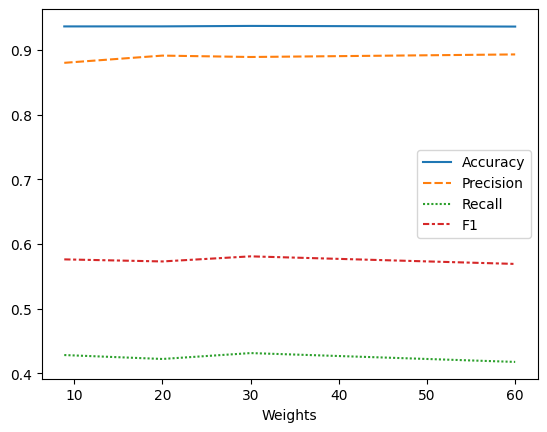

In [13]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["Weights"])
sns.lineplot(draw_df)

Try different split ratios for undersampling training

Undersmapling with ratio 1/1
Accuracy:   0.8739709163653151
Precision:  0.4432661717921527
Recall:     0.9521640091116174
F1:         0.6049204052098408


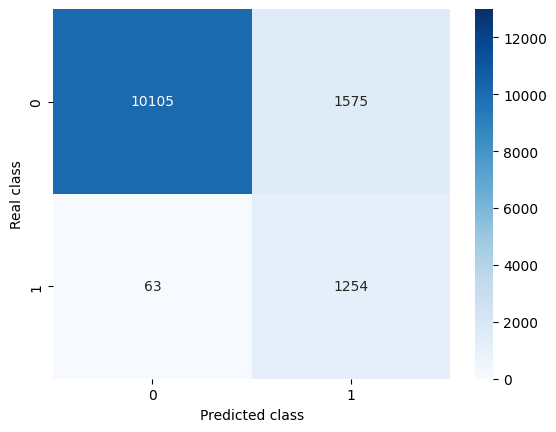

Undersmapling with ratio 1/2
Accuracy:   0.9259059783026853
Precision:  0.5921875
Recall:     0.8633257403189066
F1:         0.7025023169601483


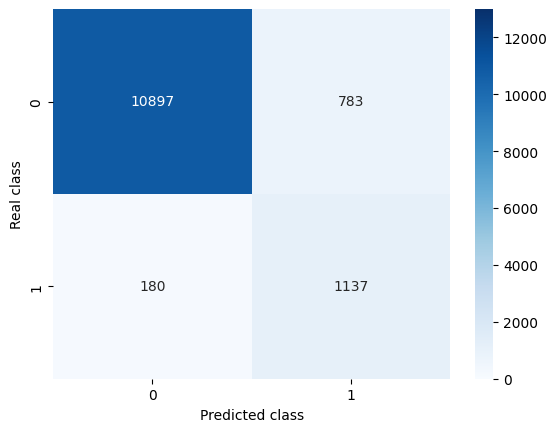

Undersmapling with ratio 1/3
Accuracy:   0.9393706239901516
Precision:  0.675981370592149
Recall:     0.7714502657555049
F1:         0.7205673758865249


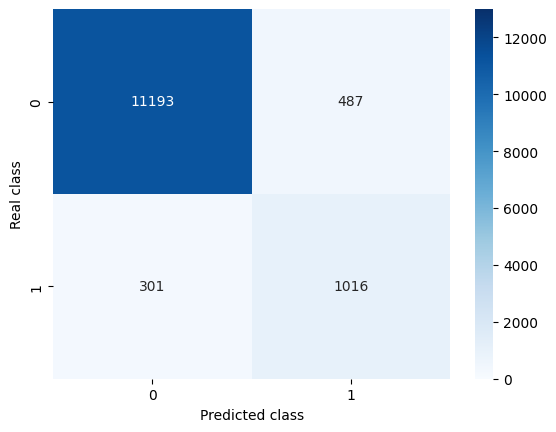

Undersmapling with ratio 1/4
Accuracy:   0.9462183580826344
Precision:  0.7508116883116883
Recall:     0.7023538344722855
F1:         0.7257748136524127


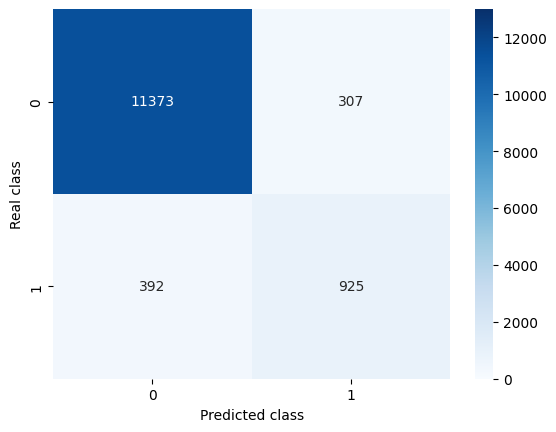

In [14]:
N = Y[Y == 1].size  # number of variable stars
new_train = pd.concat([X, Y], axis=1)

draw_data = []
for r in [1, 2, 3, 4]:
  _temp = pd.concat([new_train[new_train.present == 0].sample(N * r),
                     new_train[new_train.present == 1].sample(N)])
  X, Y = _temp.drop("present", axis=1), _temp["present"]
  clf = RandomForestClassifier(n_jobs=-1)
  clf.fit(X, Y)
  print(f"Undersmapling with ratio 1/{r}")
  draw_data.append(metrics(clf.predict(x), y))
  draw_data[-1]["Ratio"] = r

<Axes: xlabel='Ratio'>

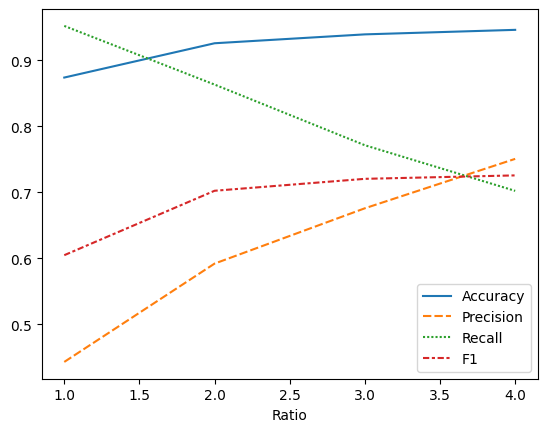

In [15]:
draw_df = pd.DataFrame(draw_data)
draw_df = draw_df.set_index(["Ratio"])
sns.lineplot(draw_df)

### Hyperparameter tuning

Будем тренировать не с балансировкой, а с меньшим датасетом, так как он показывает результаты получше. Ну может это и странно, что я опираюсь на результаты для теста, надо потом проверить с другим рандомным состоянием.

Балансировку выберем не 1/1, опять же по тесту, видимо есть золотая середина между размером выборки и ее сбалансированностью.

In [16]:
_temp = pd.concat([new_train[new_train.present == 0].sample(N * 3),
                     new_train[new_train.present == 1].sample(N)])
X, Y = _temp.drop("present", axis=1), _temp["present"]

In [17]:
params = {
  "n_estimators": [100, 300, 500],
  "max_depth": [8, 16, 32],  # FIXME: maybe too deep??
  # "min_samples_leaf" minimum samples from dataset for a node
  # "min_samples_split": [],  let's say we don't need simple trees, but overfitting?
  "n_jobs": [-1]
}

clf = GridSearchCV(RandomForestClassifier(), params)
clf.fit(X, Y)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 16, 32],
                         'n_estimators': [100, 300, 500], 'n_jobs': [-1]})

Этот результат более надежный, так как модели при тренировке проходили кросс-валидацию, значит мы, условно, не подбирали параметры по тестовой выборке.

Матрица стала намного лучше, теперь отношение True positive и False negative гораздо удобоваримее.

Accuracy:   0.9408324998076479
Precision:  0.6831550802139037
Recall:     0.7760060744115413
F1:         0.7266263775328831


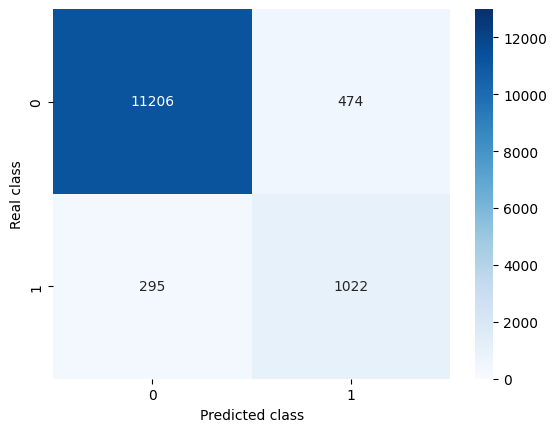

In [18]:
metrics(clf.best_estimator_.predict(x), y, to_return=False)

### Combine high recall and high precision

In [19]:
_temp = pd.concat([new_train[new_train.present == 0].sample(N * 3),
                   new_train[new_train.present == 1].sample(N)])
X, Y = _temp.drop("present", axis=1), _temp["present"]

In [26]:
params = {
    "n_estimators": [100],
    "class_weight": [{1: 10}, {1: 20}, {1: 40}],  # high penalty for false positive
    "max_depth": [8, 16, 32],
}
rf_precision = GridSearchCV(RandomForestClassifier(
), params, scoring='precision', n_jobs=-1).fit(X, Y).best_estimator_
rf_precision

RandomForestClassifier(class_weight={1: 10}, max_depth=32)

Accuracy:   0.939216742325152
Precision:  0.6862190812720848
Recall:     0.7372817008352316
F1:         0.7108345534407028


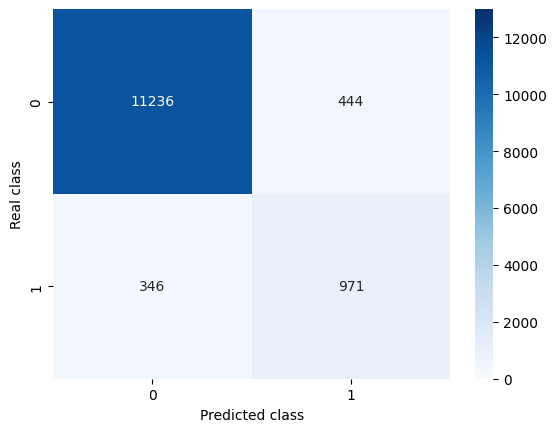

In [27]:
metrics(rf_precision.predict(x), y, to_return=False)

In [22]:
params = {
    "n_estimators": [200],
    "class_weight": [{0: 10}, {0: 20}, {0: 40}],  # high penalty for FN
    "max_depth": [8, 16]
}
rf_recall = GridSearchCV(RandomForestClassifier(
), params, scoring='recall', n_jobs=-1).fit(X, Y).best_estimator_
rf_recall

RandomForestClassifier(class_weight={0: 10}, max_depth=16, n_estimators=200)

Accuracy:   0.9259059783026853
Precision:  0.7528571428571429
Recall:     0.40015186028853456
F1:         0.5225582548339117


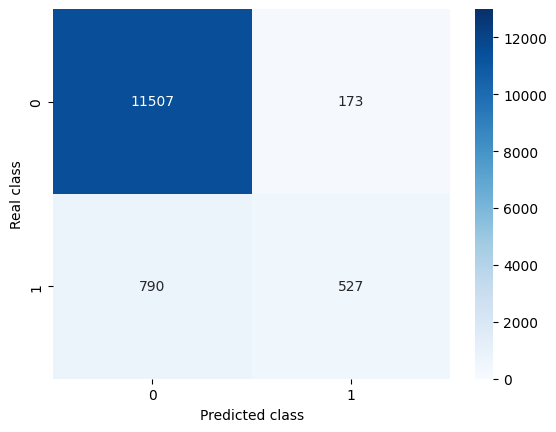

In [23]:
metrics(rf_recall.predict(x), y, to_return=False)

In [24]:
ensemble = VotingClassifier(
    estimators=[
        ('precision_model', RandomForestClassifier(class_weight={1: 10}, max_depth=16, n_estimators=200)),
        ('recall_model', RandomForestClassifier(class_weight={0: 10}, max_depth=16, n_estimators=200))
    ],
    voting='hard'  # just majority vote
)

ensemble.fit(X, Y)

VotingClassifier(estimators=[('precision_model',
                              RandomForestClassifier(class_weight={1: 10},
                                                     max_depth=16,
                                                     n_estimators=200)),
                             ('recall_model',
                              RandomForestClassifier(class_weight={0: 10},
                                                     max_depth=16,
                                                     n_estimators=200))])

Accuracy:   0.9278294991151804
Precision:  0.7984251968503937
Recall:     0.38496583143507973
F1:         0.5194672131147541


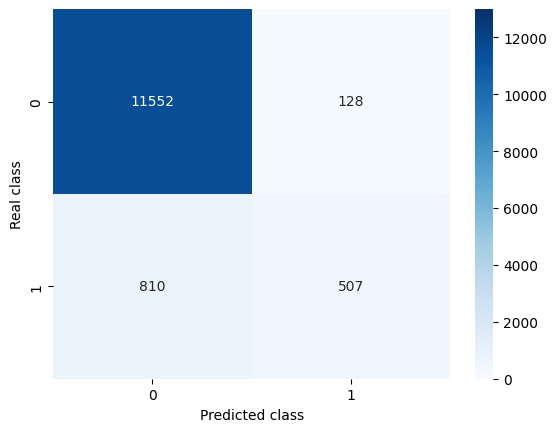

In [25]:
metrics(ensemble.predict(x), y, to_return=False)